## 1. Problem Statement

* Company: "StreamFlix" - A subscription-based streaming service
* Challenge: Losing 15% of customers every month (high churn rate)
* Cost: Each lost customer = $500 in lifetime value
* Your Mission: Build a production ML system to predict which customers will cancel next month

## 2. Data and Libraries Load
### Libraries load



In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import math
import warnings
from scipy.stats import chi2_contingency
warnings.filterwarnings("ignore")

%matplotlib inline

### Data load

In [2]:
data_df = pd.read_csv('/Users/hypernova/Public/Akash Stuff/Stream_Flix/StreamFlix_Churn_Analysis/data/raw/Customer-Churn.csv')

### Top 5 Rows

In [3]:
data_df.head(5).T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


### Shape of the dataset

In [4]:
data_df.shape

(7043, 21)

### Summary of the dataset

In [5]:
data_df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [6]:
data_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   str    
 1   gender            7043 non-null   str    
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   str    
 4   Dependents        7043 non-null   str    
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   str    
 7   MultipleLines     7043 non-null   str    
 8   InternetService   7043 non-null   str    
 9   OnlineSecurity    7043 non-null   str    
 10  OnlineBackup      7043 non-null   str    
 11  DeviceProtection  7043 non-null   str    
 12  TechSupport       7043 non-null   str    
 13  StreamingTV       7043 non-null   str    
 14  StreamingMovies   7043 non-null   str    
 15  Contract          7043 non-null   str    
 16  PaperlessBilling  7043 non-null   str    
 17  Paymen

### Exploring data

#####  - Found 11 rows where total charges were blank. Hence, removing them

In [7]:
len(data_df[data_df['TotalCharges'] == " "])

11

In [8]:
data_df = data_df[data_df['TotalCharges'] != " "]

### Data transformation - Converting SeniorCitizen to categorical

In [9]:
data_df['SeniorCitizen'] = data_df['SeniorCitizen'].replace({0:'No',1:'Yes'})

### Data transformation - Converting TotalCharges to float

In [10]:
data_df['TotalCharges'] = pd.to_numeric(data_df['TotalCharges'])

### Categorical and Numerical Features

In [18]:
categorical_cols = [cols for cols in data_df.columns if data_df[cols].dtype != 'float' and (cols != 'customerID' and cols != 'tenure')]
numercial_cols = [cols for cols in data_df.columns if data_df[cols].dtype == 'float']

In [19]:
#proportion of count data on categorical columns

for col in categorical_cols:
    print(f"------------------{col} proportion-----------------")
    print(data_df[col].value_counts(normalize=True)*100)

------------------gender proportion-----------------
gender
Male      50.469283
Female    49.530717
Name: proportion, dtype: float64
------------------SeniorCitizen proportion-----------------
SeniorCitizen
No     83.759954
Yes    16.240046
Name: proportion, dtype: float64
------------------Partner proportion-----------------
Partner
No     51.749147
Yes    48.250853
Name: proportion, dtype: float64
------------------Dependents proportion-----------------
Dependents
No     70.150739
Yes    29.849261
Name: proportion, dtype: float64
------------------PhoneService proportion-----------------
PhoneService
Yes    90.32992
No      9.67008
Name: proportion, dtype: float64
------------------MultipleLines proportion-----------------
MultipleLines
No                  48.137088
Yes                 42.192833
No phone service     9.670080
Name: proportion, dtype: float64
------------------InternetService proportion-----------------
InternetService
Fiber optic    44.027304
DSL            34.357224


### Insights

* Senior citizens are 17% of total population

* 74% don't have any partner

* Gender proportion has higher males

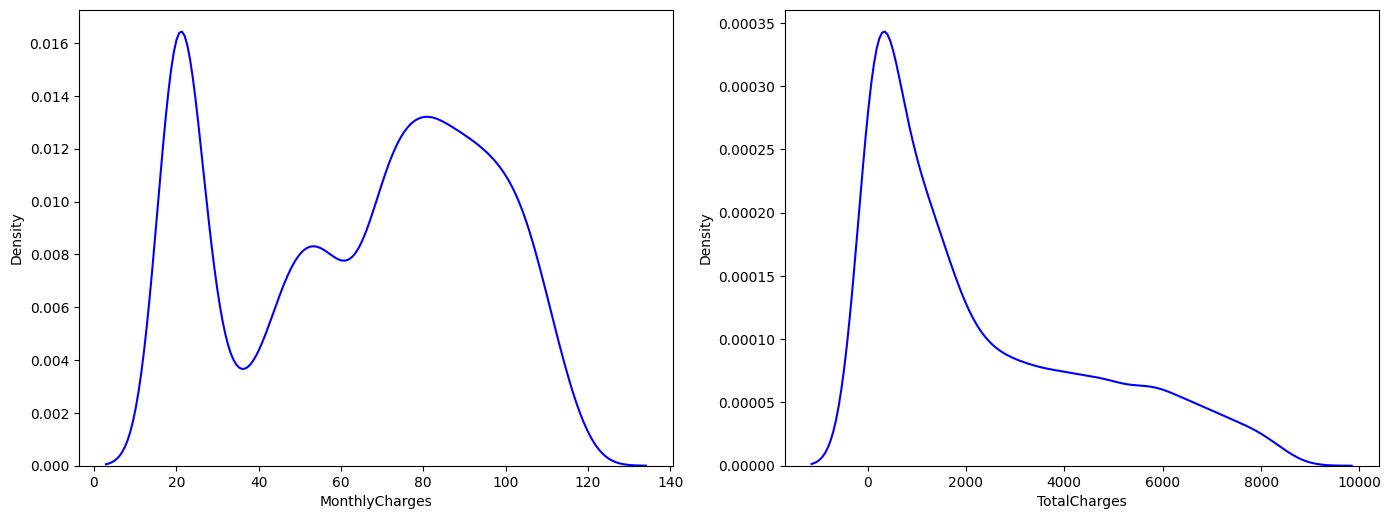

In [20]:
plt.figure(figsize = (14,10))

for i in range(0, len(numercial_cols)):
    plt.subplot(2,2,i+1)
    sns.kdeplot(x = data_df[numercial_cols[i]],color='blue')
    plt.xlabel(numercial_cols[i])
    plt.tight_layout()


### Insights


* Monthly Charges show bimodal distribution

* TotalCharges are skewed towards right

6


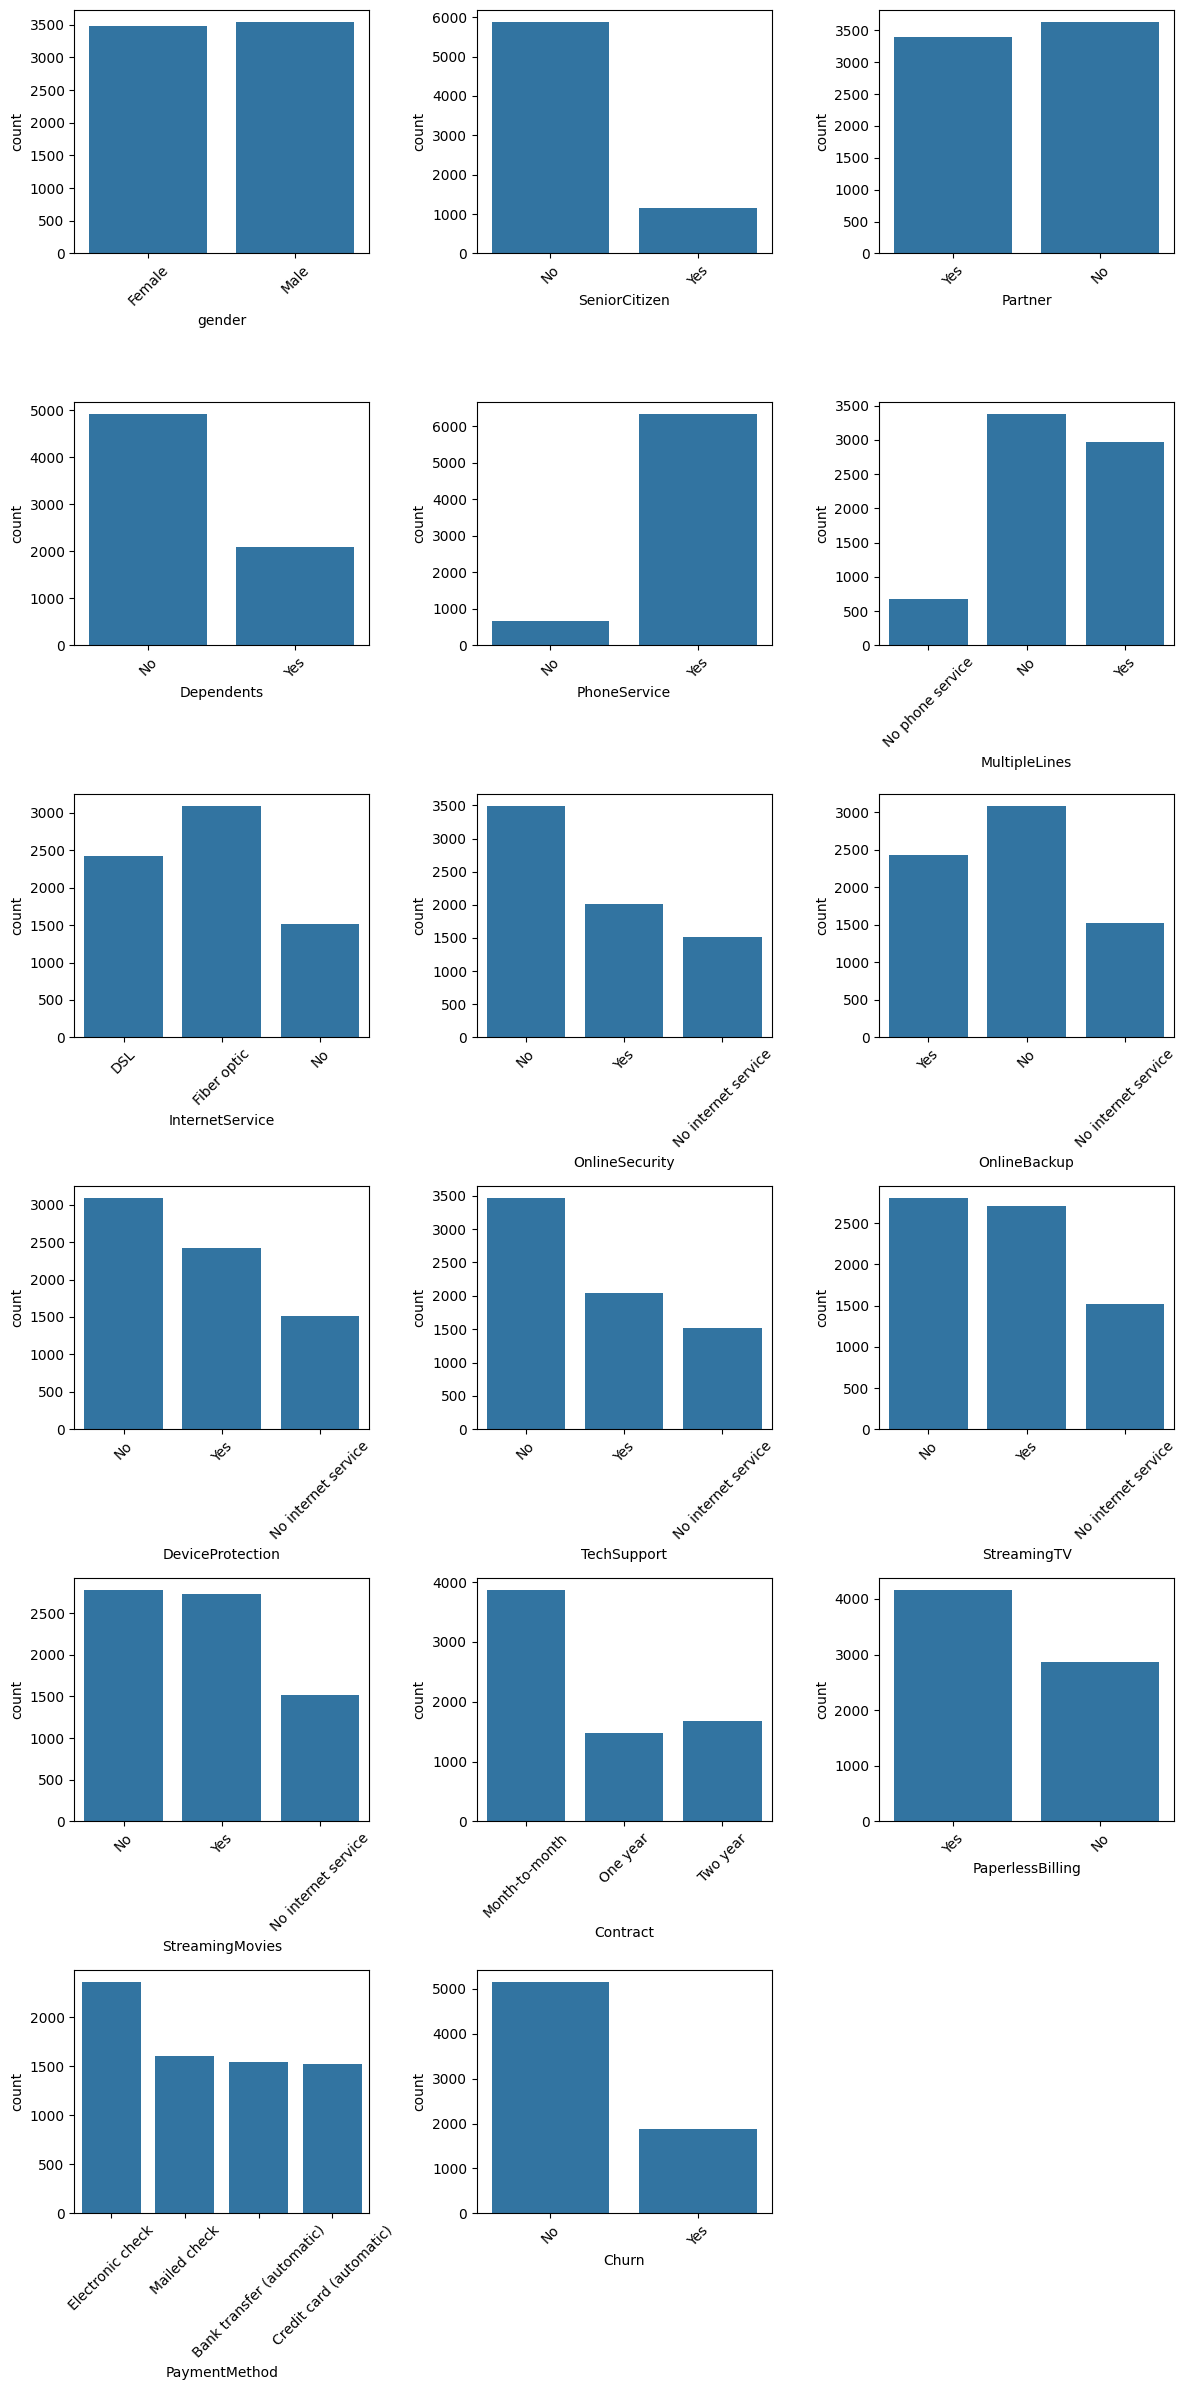

In [25]:
plt.figure(figsize = (12,24))

rows = math.ceil(len(categorical_cols)/3)

print(rows)

for i in range(0,len(categorical_cols)):
    plt.subplot(rows,3,i+1)
    sns.countplot(x = data_df[categorical_cols[i]])
    plt.xticks(rotation=45)
    
plt.tight_layout()

### Chi square test for multicollinearity

In [29]:
for cols in categorical_cols:
    if (chi2_contingency(pd.crosstab(data_df['Churn'],data_df[col]))[1]) <=0.05:
        print(f"For Col {cols}, reject null hypothesis -> Significant ")
    else:
        print(f"For Col {cols}, fail to reject null hypothesis -> Not significant ")

For Col gender, reject null hypothesis -> Significant 
For Col SeniorCitizen, reject null hypothesis -> Significant 
For Col Partner, reject null hypothesis -> Significant 
For Col Dependents, reject null hypothesis -> Significant 
For Col PhoneService, reject null hypothesis -> Significant 
For Col MultipleLines, reject null hypothesis -> Significant 
For Col InternetService, reject null hypothesis -> Significant 
For Col OnlineSecurity, reject null hypothesis -> Significant 
For Col OnlineBackup, reject null hypothesis -> Significant 
For Col DeviceProtection, reject null hypothesis -> Significant 
For Col TechSupport, reject null hypothesis -> Significant 
For Col StreamingTV, reject null hypothesis -> Significant 
For Col StreamingMovies, reject null hypothesis -> Significant 
For Col Contract, reject null hypothesis -> Significant 
For Col PaperlessBilling, reject null hypothesis -> Significant 
For Col PaymentMethod, reject null hypothesis -> Significant 
For Col Churn, reject nu

#### Target Variable Analysis

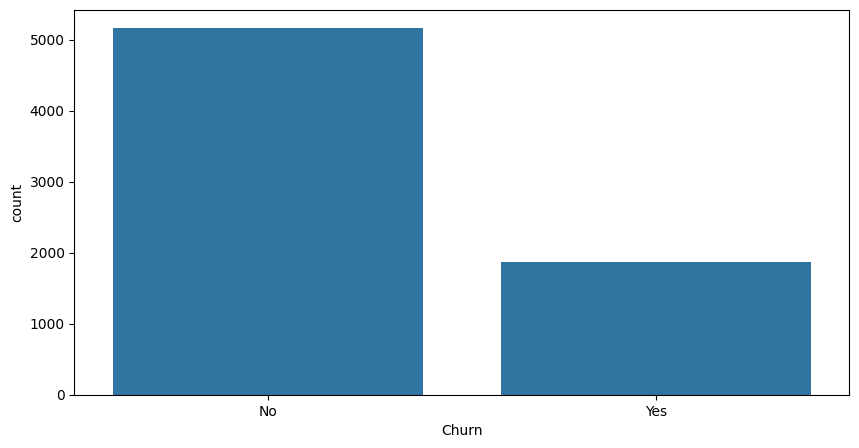

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data = data_df, x='Churn')
plt.show()

### Insight

target variable has imbalanced data

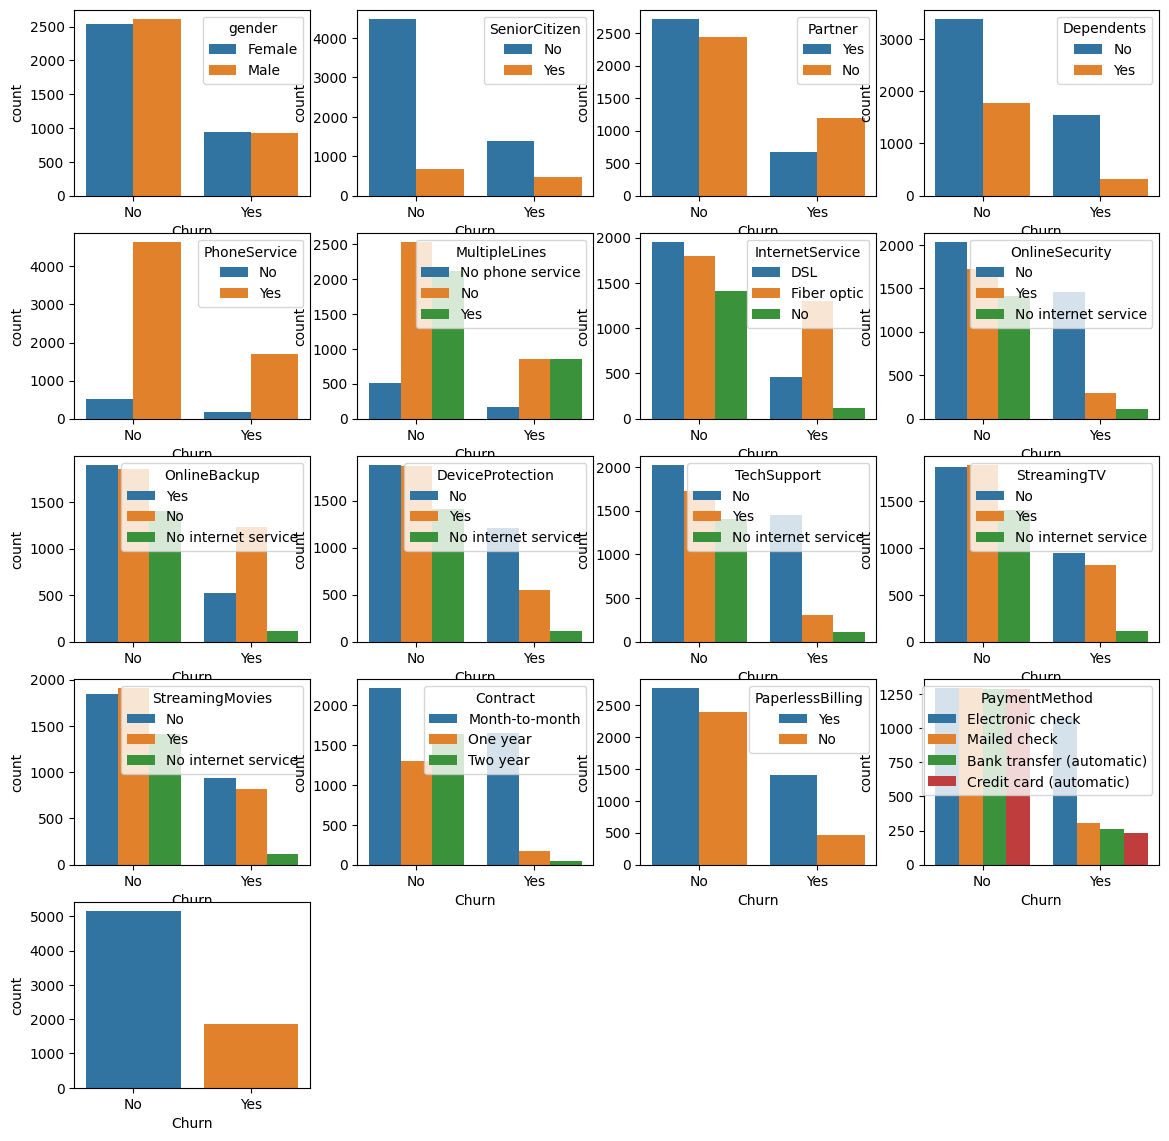

In [37]:
plt.figure(figsize=(14,14))

rows = math.ceil(len(categorical_cols)/4)

for i in range(0, len(categorical_cols)):
    plt.subplot(rows,4,i+1)
    sns.countplot(data = data_df, x = 'Churn', hue = categorical_cols[i])